In [1]:
import datetime as dt
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
windows = r'C:\Users\Usuario\Downloads\effis_layer\modis.ba.poly.shp'
linux = '~/Descargas/effis_layer/modis.ba.poly.shp'

shp_effis = gpd.read_file(linux)
shp_effis.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 92772 entries, 0 to 92771
Data columns (total 19 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   id          92772 non-null  object  
 1   FIREDATE    92772 non-null  object  
 2   LASTUPDATE  92772 non-null  object  
 3   COUNTRY     92764 non-null  object  
 4   PROVINCE    92772 non-null  object  
 5   COMMUNE     92772 non-null  object  
 6   AREA_HA     92772 non-null  object  
 7   BROADLEA    92121 non-null  object  
 8   CONIFER     92121 non-null  object  
 9   MIXED       92121 non-null  object  
 10  SCLEROPH    92121 non-null  object  
 11  TRANSIT     92121 non-null  object  
 12  OTHERNATLC  92121 non-null  object  
 13  AGRIAREAS   92121 non-null  object  
 14  ARTIFSURF   92121 non-null  object  
 15  OTHERLC     92121 non-null  object  
 16  PERCNA2K    92772 non-null  object  
 17  CLASS       92772 non-null  object  
 18  geometry    92772 non-null  geometry
d

In [24]:
effis = shp_effis[(shp_effis.COUNTRY == 'ES') | (shp_effis.COUNTRY == 'PT')]

In [25]:
# Calculamos centroides y extraemos coordenadas
effis['CENTROID'] = effis.geometry.centroid.to_crs('WGS 84')
effis['LAT'], effis['LON'] = effis.CENTROID.y, effis.CENTROID.x

/tmp/ipykernel_25522/2172088228.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  effis['CENTROID'] = effis.geometry.centroid.to_crs('WGS 84')
/usr/lib/python3.13/site-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/usr/lib/python3.13/site-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ret

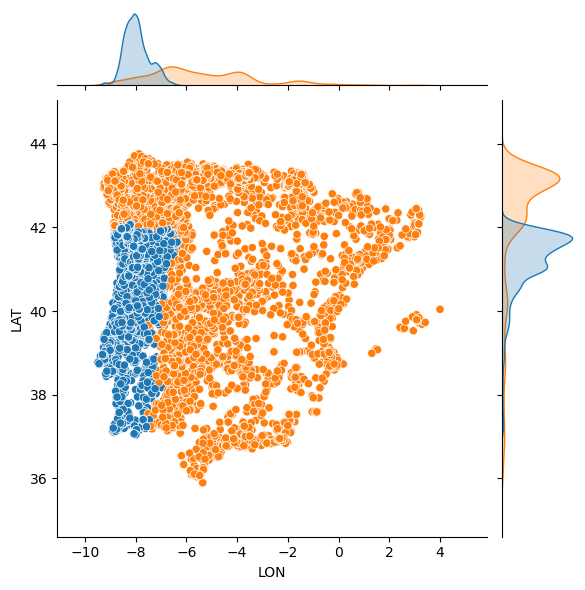

In [26]:
effis = effis.loc[(effis.LAT > 0) & (effis.LON > -10) & (effis.LON < 10)]
sns.jointplot(effis, x='LON', y='LAT', hue = 'COUNTRY', legend=False);

In [27]:
# Pasamos las columnas de inicio de incendio y última actualización a datetime 
effis.FIREDATE = pd.to_datetime(effis.FIREDATE, format='ISO8601')
effis.LASTUPDATE = pd.to_datetime(effis.LASTUPDATE, format='ISO8601')

# Eliminamos los incendios de 2025
effis = effis[effis.FIREDATE.dt.year < 2025]

# Calculamos la duración del incendio
effis['DURATION'] = effis.LASTUPDATE - effis.FIREDATE

In [28]:
# Calculamos el día juliano pero como si todos los años fueran bisiestos

def dia_juliano_bisiesto(serie):
    dias_meses = [0,31,29,31,30,31,30,31,31,30,31,30]
    lista_dias = []
    for valor in serie:
        dia_juliano = 0
        mes = valor.month
        for index in range(mes):
            dia_juliano += dias_meses[index]
        dia_juliano += valor.day
        lista_dias.append(dia_juliano)
    return lista_dias

effis['DAY_YEAR'] = dia_juliano_bisiesto(effis.FIREDATE)

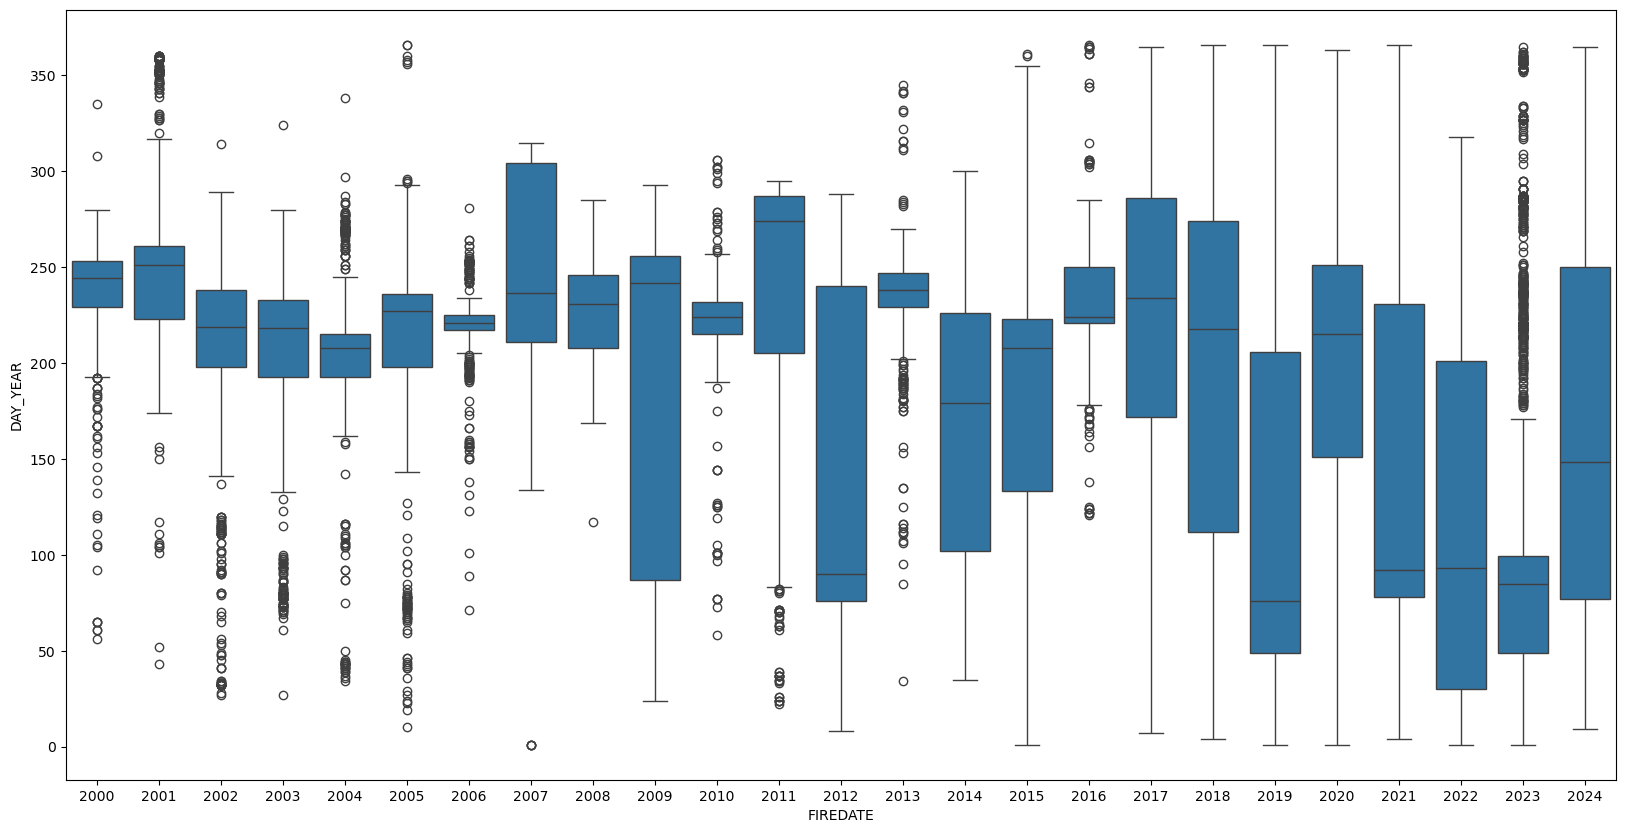

In [29]:
# Distribución de número de incendios por día juliano para cada año

plt.figure(figsize=(20, 10))
sns.boxplot(effis, x=effis.FIREDATE.dt.year, y=effis.DAY_YEAR);

In [30]:
effis.AREA_HA = effis.AREA_HA.astype(int)

In [33]:
effis = effis[effis.AREA_HA>499]

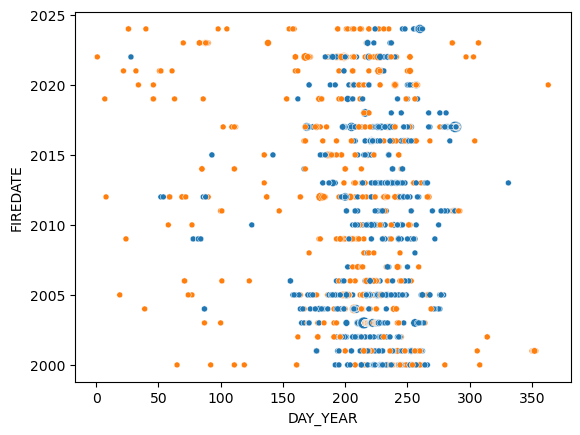

In [41]:
sns.scatterplot(effis, x='DAY_YEAR', y=effis.FIREDATE.dt.year, size = 'AREA_HA', hue='COUNTRY', legend=False);

In [40]:
effis.groupby(['COUNTRY','PROVINCE'])['AREA_HA'].sum().sort_values(ascending=False)

COUNTRY  PROVINCE                 
PT       Beiras e Serra da Estrela    346456
         Viseu Dão Lafões             241666
         Região de Coimbra            222304
         Algarve                      208785
         Médio Tejo                   202027
                                       ...  
ES       Cádiz                          1610
         Eivissa y Formentera           1424
         Palencia                        684
         Bizkaia                         665
         Gipuzkoa                        501
Name: AREA_HA, Length: 69, dtype: int64